# LSTM Autoencoder 
## Tennessee Eastman Process Simulation Dataset

Source: https://www.kaggle.com/datasets/averkij/tennessee-eastman-process-simulation-dataset

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from model.autoencoder import LSTMAutoencoder, LSTMAutoencoderTransformer
from data.process import TEPDataLoader
from data.utils import get_missing_values_table

import plotly.graph_objects as go
import plotly.express as px 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn import set_config
set_config(display="diagram")

# from pandarallel import pandarallel

# pandarallel.initialize(progress_bar=True)

2022-05-03 17:30:09.227871: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 17:30:09.227950: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Exploratory Data Analysis
### Loading datasets

A total of 4 datasets are available, already split into train and test. From the data source, the following complete description is available: 

* Each dataframe contains 55 columns:

  * Column 1 ('faultNumber') ranges from 1 to 20 in the “Faulty” datasets and represents the fault type in the TEP. The “FaultFree” datasets only contain fault 0 (i.e. normal operating conditions).

  * Column 2 ('simulationRun') ranges from 1 to 500 and represents a different random number generator state from which a full TEP dataset was generated (Note: the actual seeds used to generate training and testing datasets were non-overlapping).

  * Column 3 ('sample') ranges either from 1 to 500 (“Training” datasets) or 1 to 960 (“Testing” datasets). The TEP variables (columns 4 to 55) were sampled every 3 minutes for a total duration of 25 hours and 48 hours respectively. Note that the faults were introduced 1 and 8 hours into the Faulty Training and Faulty Testing datasets, respectively.

* Columns 4 to 55 contain the process variables; the column names retain the original variable names.

In [2]:
# create the loader class instance
loader = TEPDataLoader('data/raw')

# load the training and test datasets
X_train_faulty, X_train_normal = loader.load_training_datasets()
# X_test_faulty, X_test_normal = loader.load_testing_datasets()

50it [01:17,  1.54s/it]
3it [00:03,  1.26s/it]


### Checking data quality
Initially, let's cehck if there is any missing data in the datasets. 

In [3]:
# let's check first for any columns with missing values
display(get_missing_values_table(X_train_faulty))
display(get_missing_values_table(X_train_normal))

Your selected dataframe has 55 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Your selected dataframe has 55 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Good! No missing data for any of the columns. This is somehow expected, since this dataset is generated from a simulated process. 

### Data Understanding
Now, let's have a look at some normal and faulty simulations, to better understand what this data means. We pick the first simulation for a normal and faulty condition. Since there can be several kinds of faults, we also choose a single one for visualization. The resulting charts are displayed below, we can notice the following:
* The data appears to be noisy. However, the sampling rate is 3 minutes, meaning the TEP has a slow dynamic behavior.
  * A low-pass filter could be applied to them in a later pre-processing step.
* There is a clear distinction between a fault and normal operation between the signals. 
  * Look for example how the "xmeas_4" variable is different between them
* Variable "xmeas_9" looks like discrete signal, as it keeps switching between fixed values.
* Some variables are highly correlated, as displayed in the hierarchically-clustered heatmap. For example:
  * x_meas7 and x_meas13
  * x_meas19 and x_mv9
  * x_meas10 and x_mv6
  * x_meas20 and x_mv5
* The same varaible remains correlated even for faulty simulations, which is expected as the system does not change it's strucuture. However, the intensity can change depending on the fault type. 

In [4]:
def plot_simulation_data(df, simulation_run, title, fault_number=0):
    process_variables = df.columns[4:]
    df_sim = df[(df.simulationRun == simulation_run)&(df.faultNumber==fault_number)]
    df_melt = pd.melt(df_sim, id_vars=['sample'], value_vars=process_variables, var_name='variable', value_name='value')
    rp = sns.relplot(data=df_melt, x='sample', y='value', col='variable', kind='line', 
                col_wrap=6, height=2,
                 facet_kws={'sharey': False, 'sharex': True})
    rp.fig.suptitle(f'{title}: Simulation #{simulation_run}')

def plot_simulation_variable(df, simulation_run, title, variable, fault_number=0):
    fig, ax = plt.subplots(figsize=(7,4))
    df_sim = df[(df.simulationRun == simulation_run)&(df.faultNumber==fault_number)]
    sns.lineplot(data=df_sim, x='sample', y=variable, ax=ax)
    fig.suptitle(f'{title}: Simulation #{simulation_run} - {variable}')

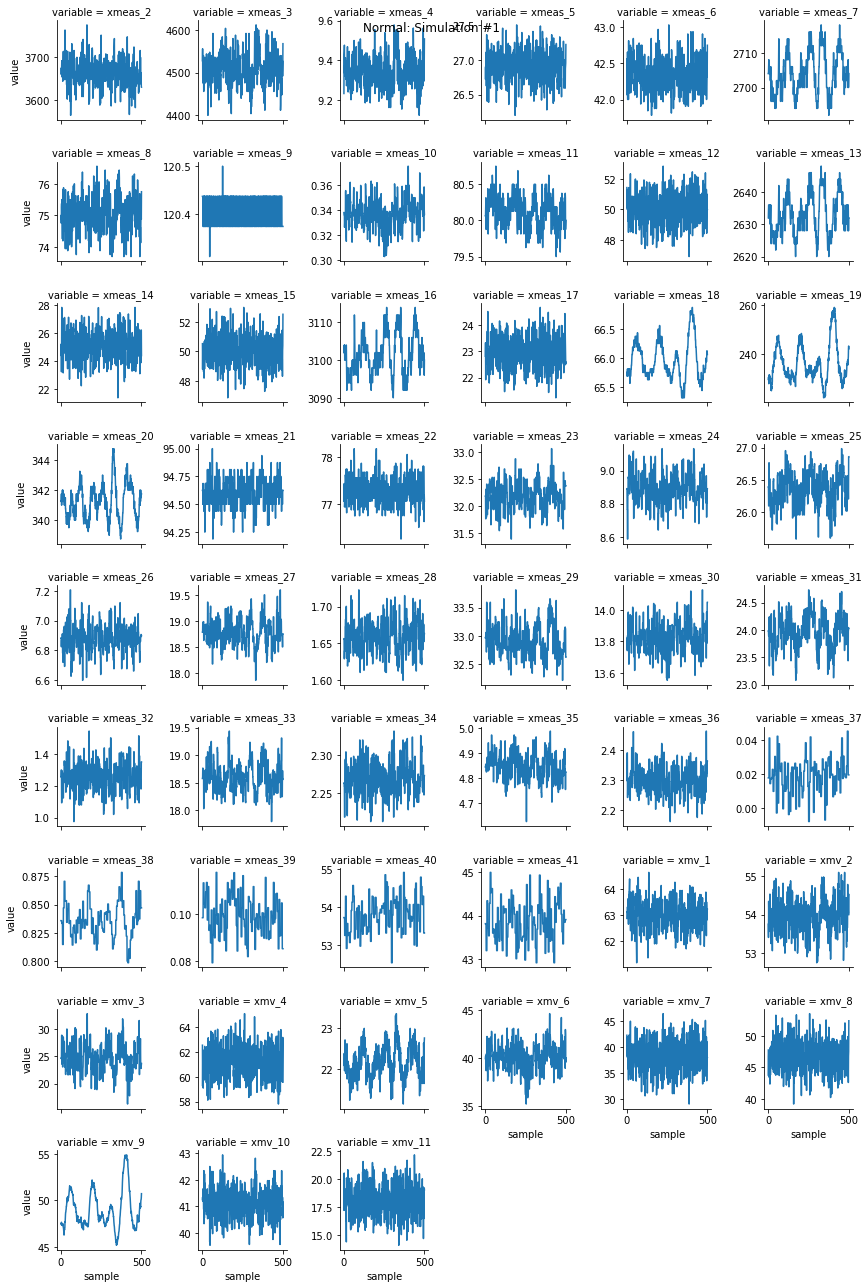

In [8]:
plot_simulation_data(X_train_normal, 1, 'Normal')

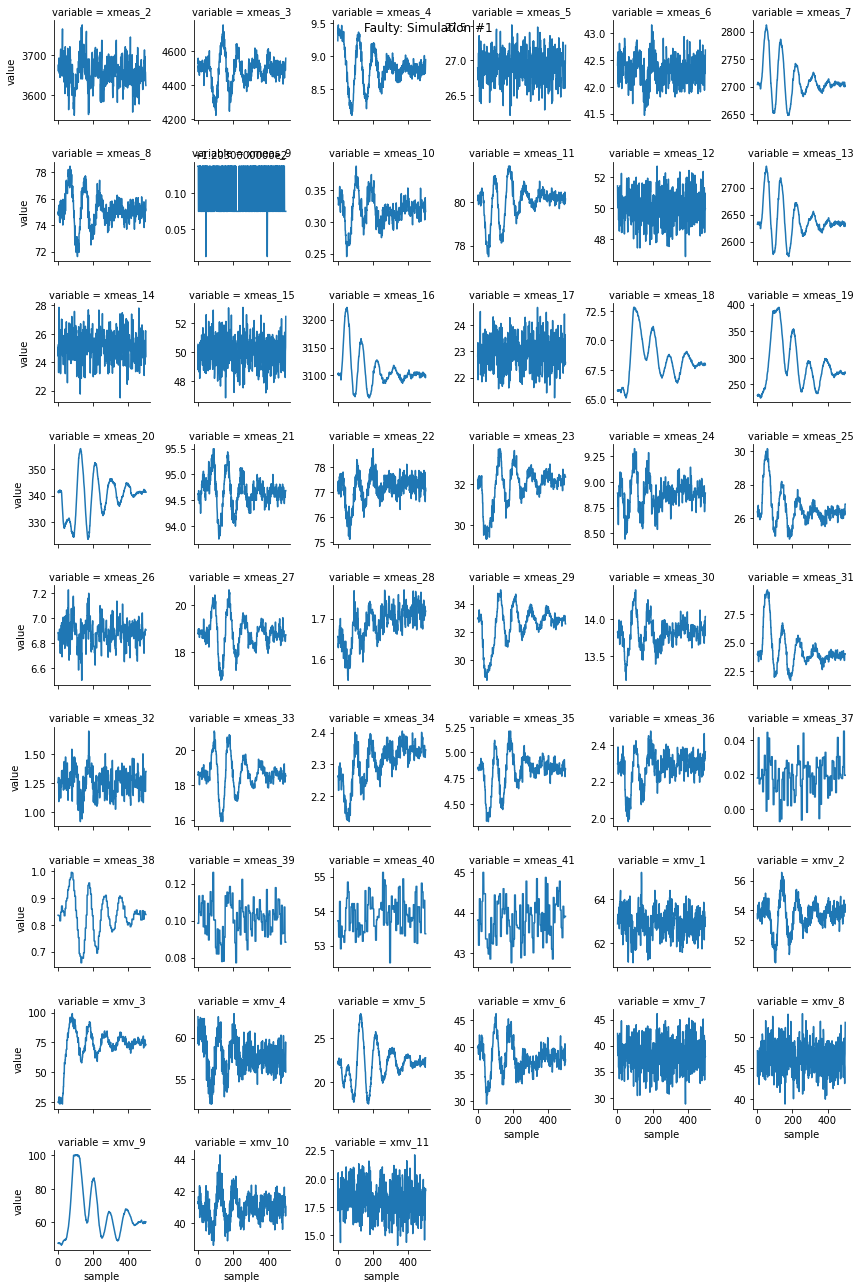

In [9]:
plot_simulation_data(X_train_faulty, 1,'Faulty', 1)

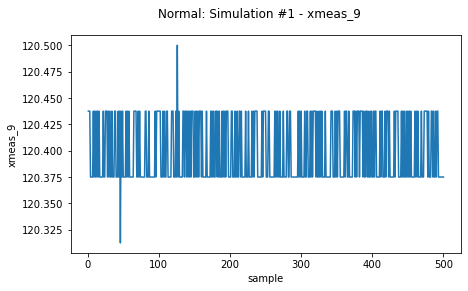

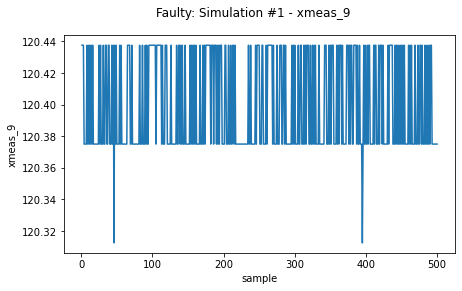

In [106]:
plot_simulation_variable(X_train_normal, 1, 'Normal', 'xmeas_9')
plot_simulation_variable(X_train_faulty, 1, 'Faulty', 'xmeas_9', 1)

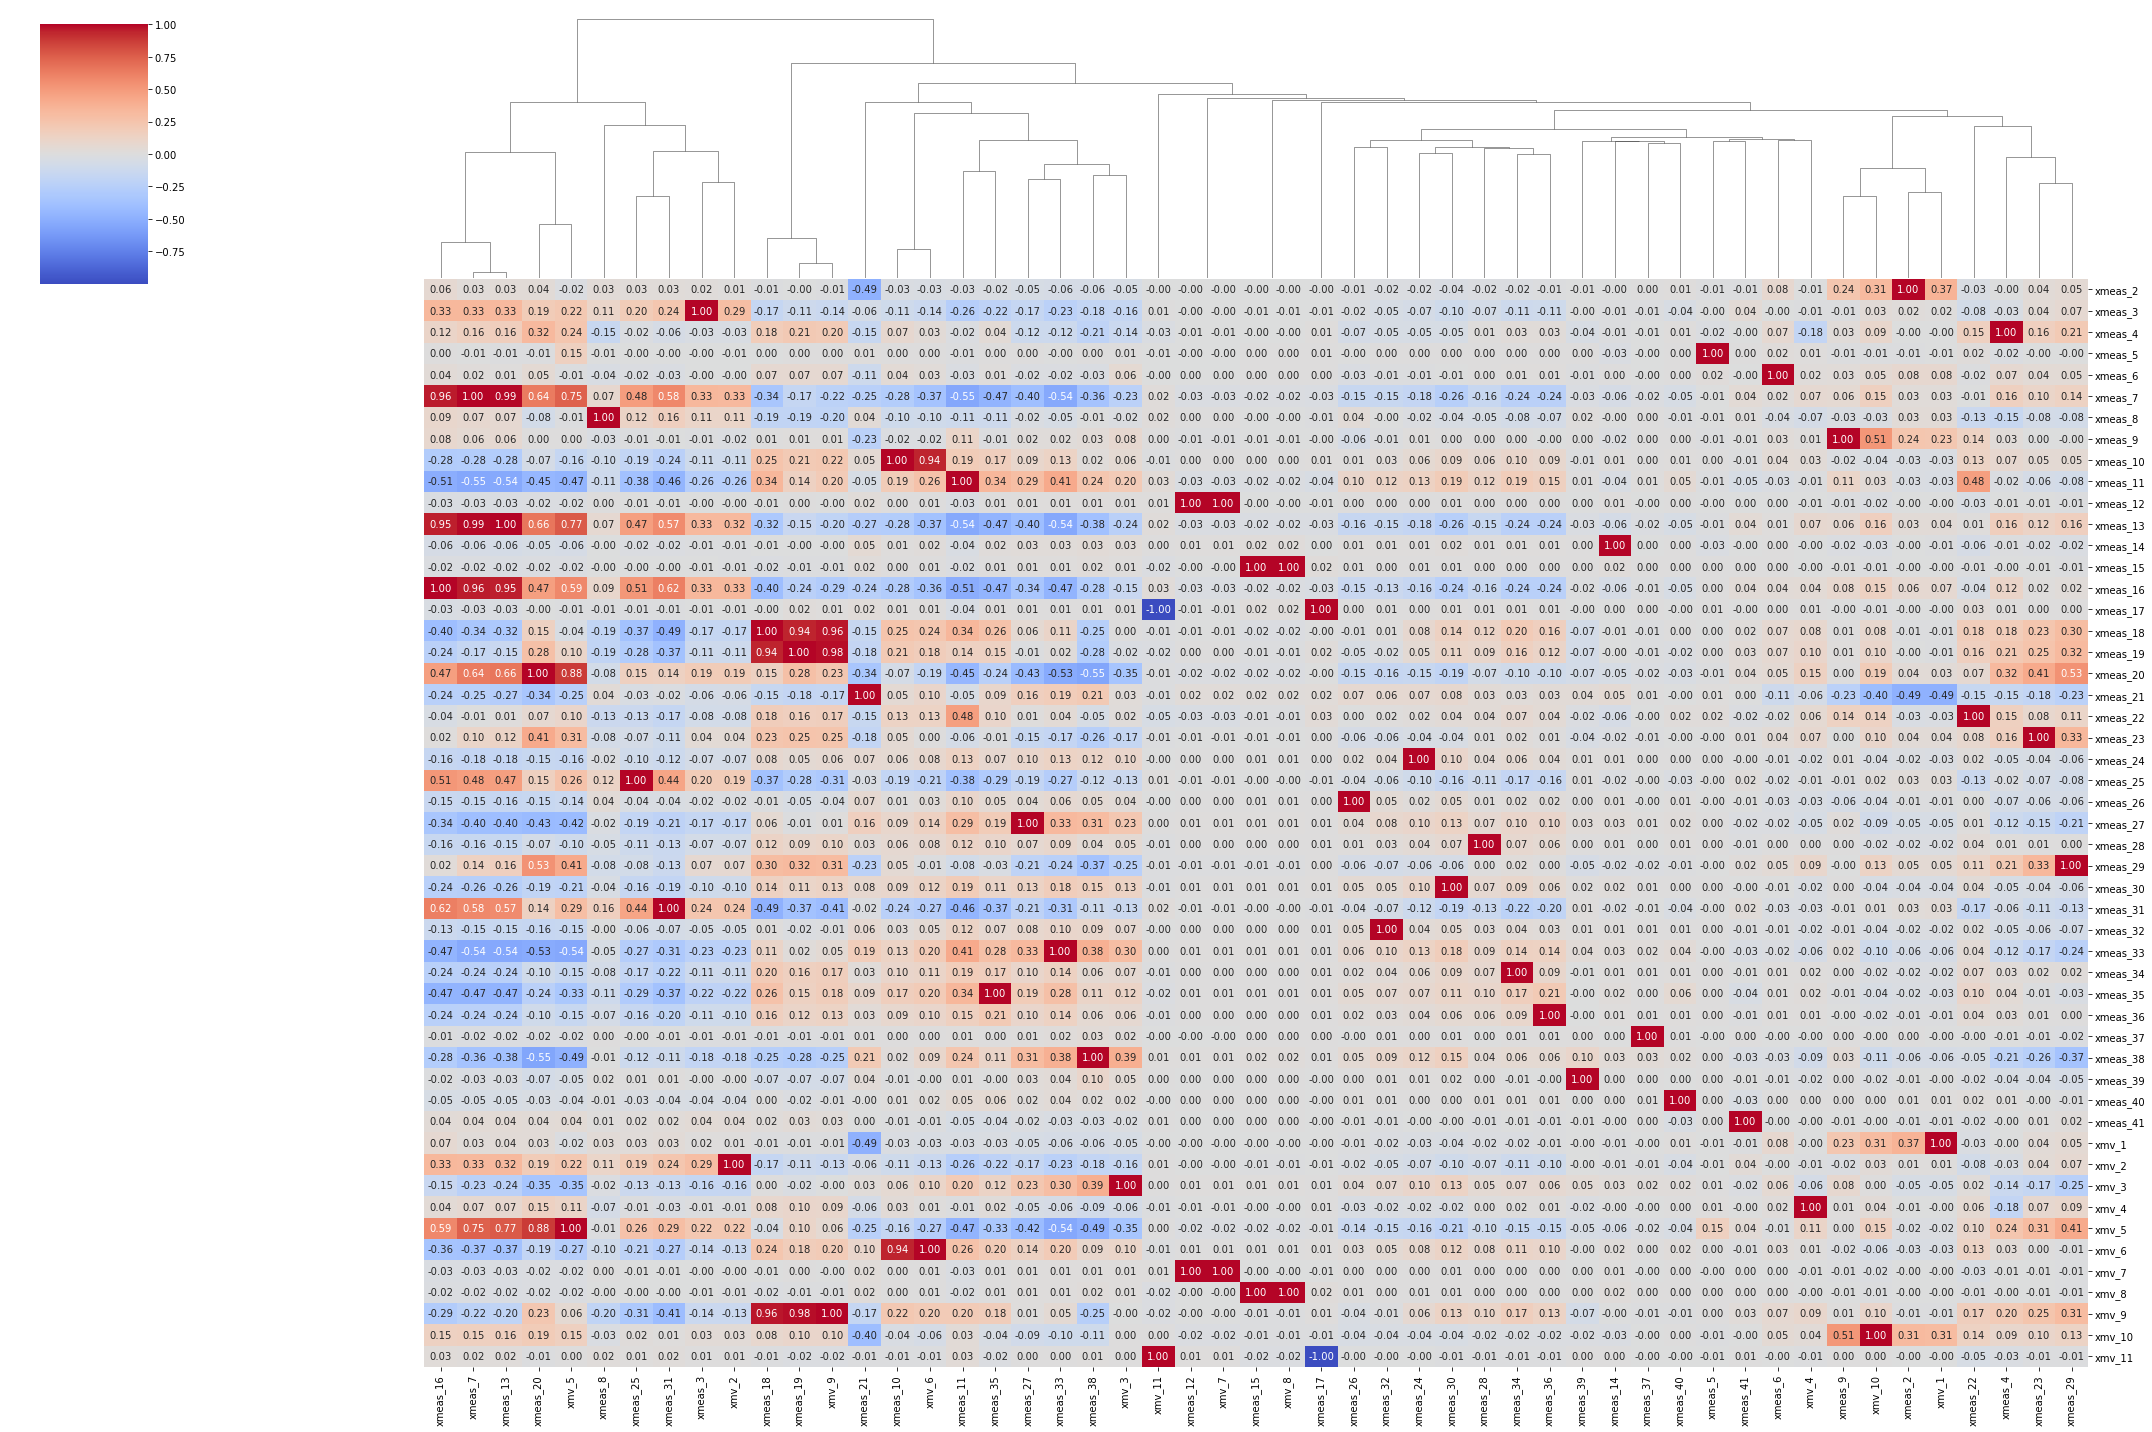

In [16]:
def plot_correlation_clustermap(df):
    corr = df.corr('spearman')
    sns.clustermap(corr, annot=True, fmt='.2f', figsize=(30,20), cmap='coolwarm', row_cluster=False)
    
plot_correlation_clustermap(X_train_normal.iloc[:,4:])

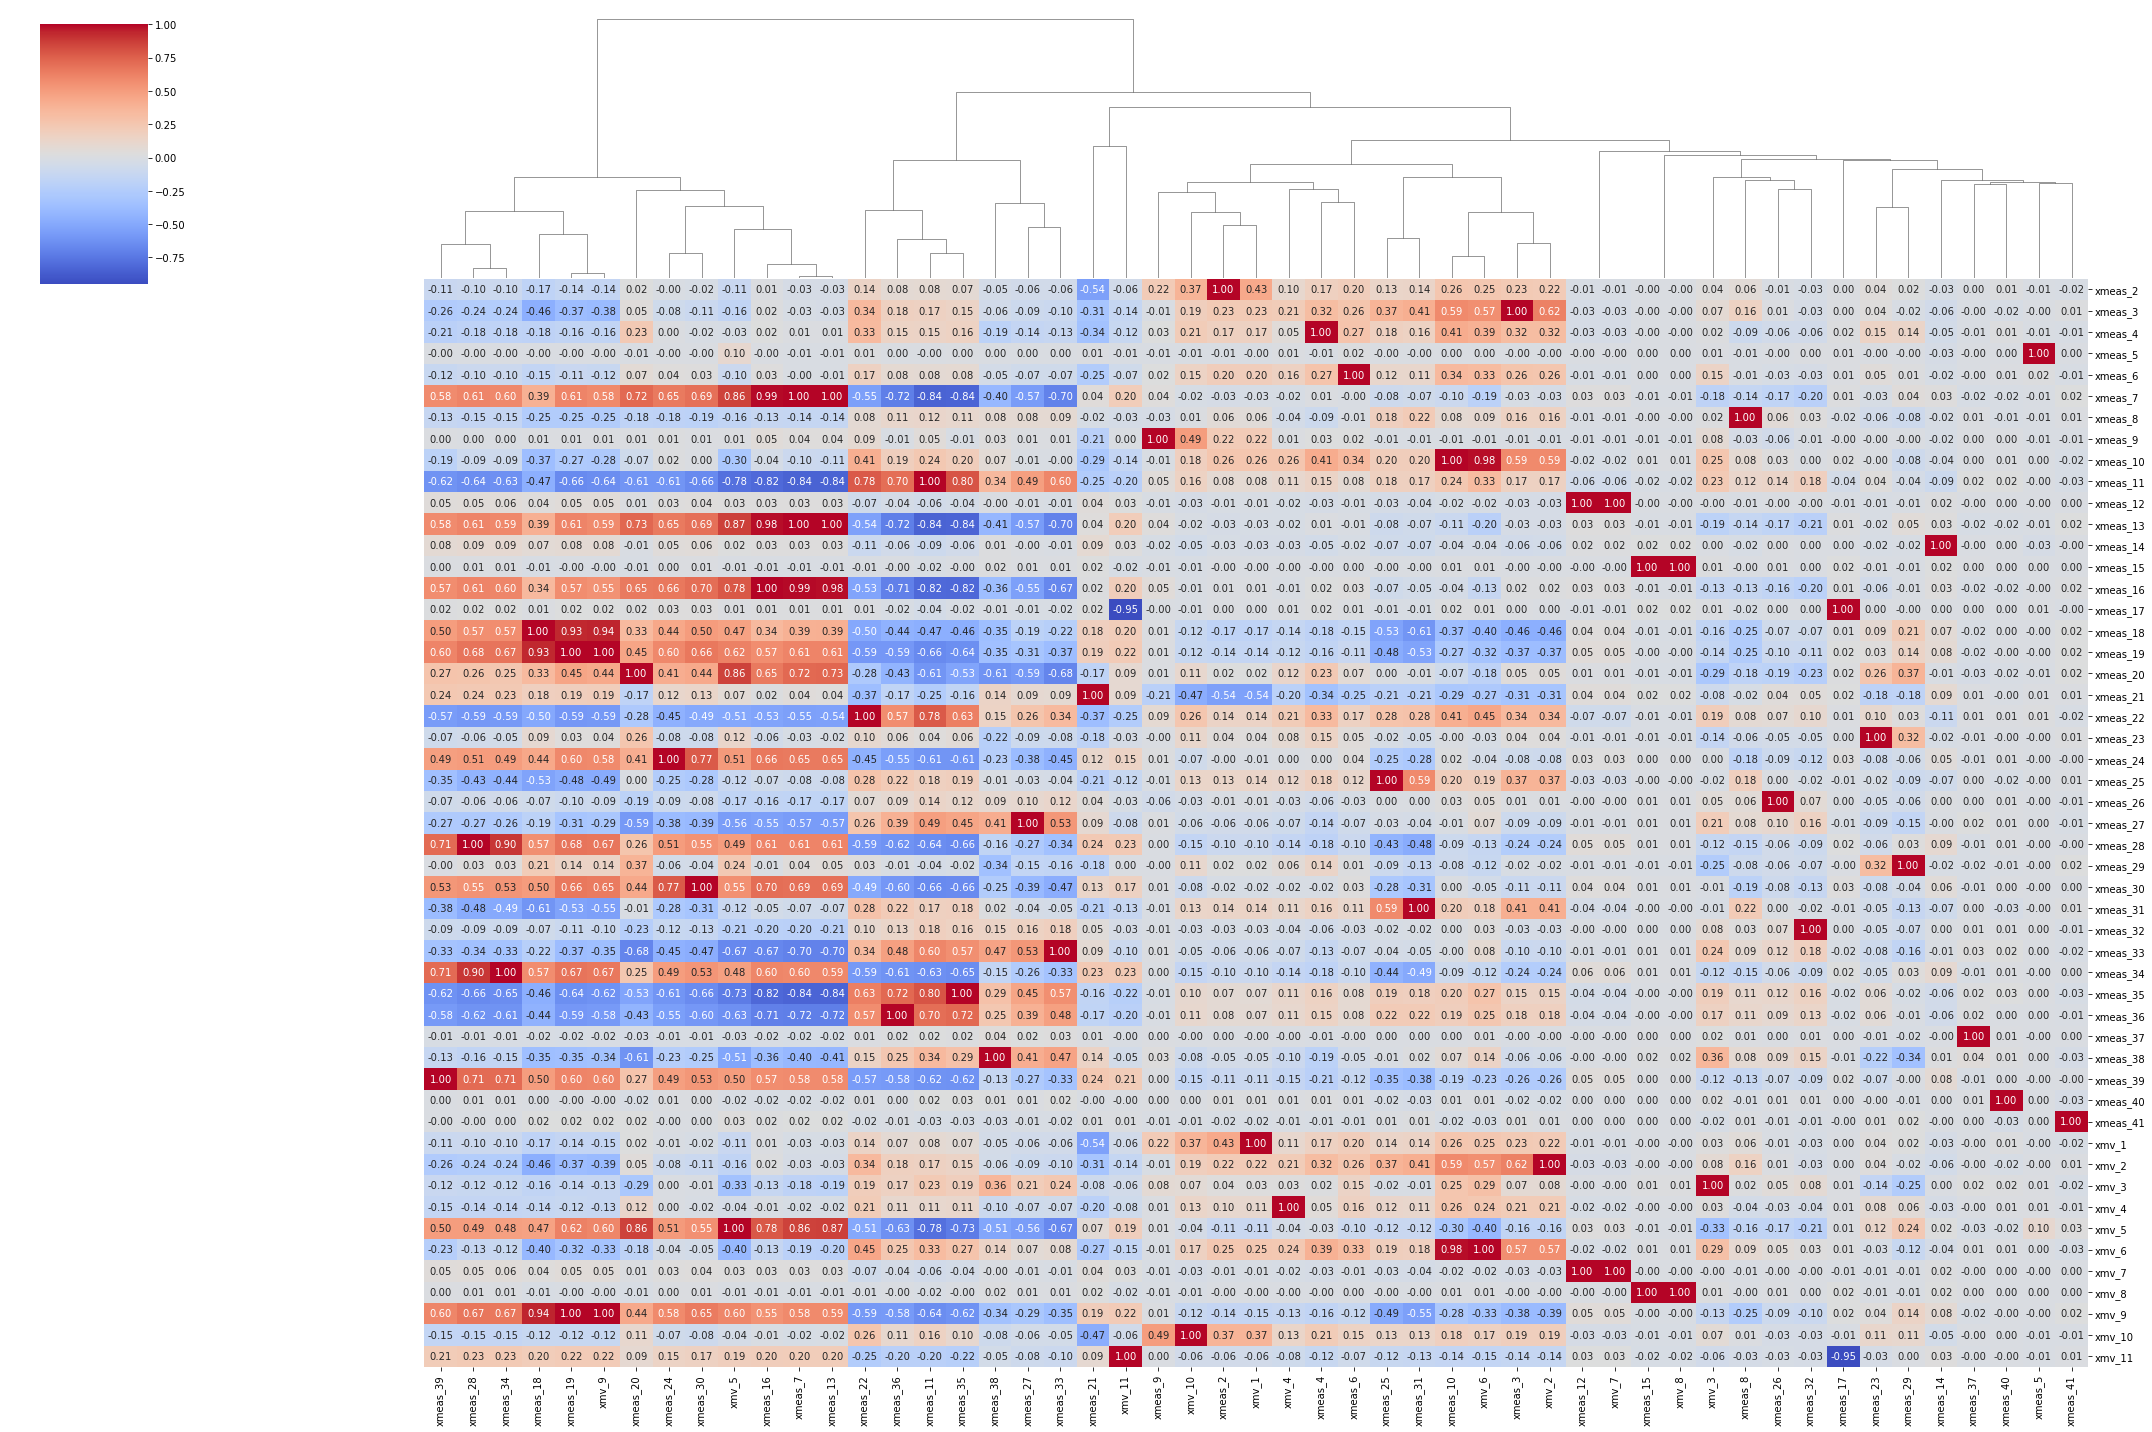

In [23]:
plot_correlation_clustermap(X_train_faulty.loc[X_train_faulty.faultNumber == 2].iloc[:,4:])

## Data Preparation

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.signal import butter,filtfilt,medfilt

class LowPassFilter(BaseEstimator, TransformerMixin):
    def __init__(self, fs, cutoff = 1000, order=2):
        self.fs = fs
        self.nyq = 0.5 * fs
        self.cutoff = cutoff
        self.order = order

    def _butter_lowpass_filter(self):
        normal_cutoff = self.cutoff / self.nyq
        # Get the filter coefficients 
        b, a = butter(self.order, normal_cutoff, btype='low', analog=False)
        return b, a
    
    def _apply_filter(self, X):
        filter_signal = lambda x: filtfilt(self.b, self.a, x)
        X_filt = X.drop(columns=['sample', 'faultNumber', 'simulationRun']).apply(filter_signal)
        return pd.concat([X[['faultNumber', 'simulationRun', 'sample']], X_filt], axis=1)

    def fit(self, X, y=None):
        self.b, self.a = self._butter_lowpass_filter()
        return self
    
    def transform(self, X):
        return X.groupby(['faultNumber', 'simulationRun']).apply(self._apply_filter)


class MedianFilter(BaseEstimator, TransformerMixin):
    def __init__(self, window=21):
        self.window = window
 
    def _apply_filter(self, X):
        X_filt = X.drop(columns=['sample', 'faultNumber', 'simulationRun']).apply(lambda x: medfilt(x.astype(float), self.window))
        return pd.concat([X[['faultNumber', 'simulationRun', 'sample']], X_filt], axis=1)

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.groupby(['faultNumber', 'simulationRun']).apply(self._apply_filter)


class RollingAverageFilter(BaseEstimator, TransformerMixin):
    def __init__(self, window=5):
        self.window = window
 
    def _apply_filter(self, X):
        X_filt = X.drop(columns=['sample', 'faultNumber', 'simulationRun']).apply(lambda x: x.rolling(self.window).mean().dropna())
        return pd.concat([X[['faultNumber', 'simulationRun', 'sample']], X_filt], axis=1)

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.groupby(['faultNumber', 'simulationRun']).apply(self._apply_filter)

    
class EWMAverageFilter(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.8):
        self.alpha = alpha
 
    def _apply_filter(self, X):
        X_filt = X.drop(columns=['sample', 'faultNumber', 'simulationRun']).apply(lambda x: x.ewm(self.alpha).mean().dropna())
        return pd.concat([X[['faultNumber', 'simulationRun', 'sample']], X_filt], axis=1)

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.groupby(['faultNumber', 'simulationRun']).apply(self._apply_filter)

In [6]:
# median filtering
X_median_filtered = MedianFilter(window=5).transform(X_train_normal)

# rolling average smothing
X_rollavg_filtered = RollingAverageFilter(window=5).transform(X_train_normal)

# EWMA
X_ewma_filtered = EWMAverageFilter().transform(X_train_normal)

fs = 1 / (3 * 60) # sampling frequency for 3 minutes period
X_butter_filtered = LowPassFilter(fs, fs*0.4, 5).fit_transform(X_train_normal)

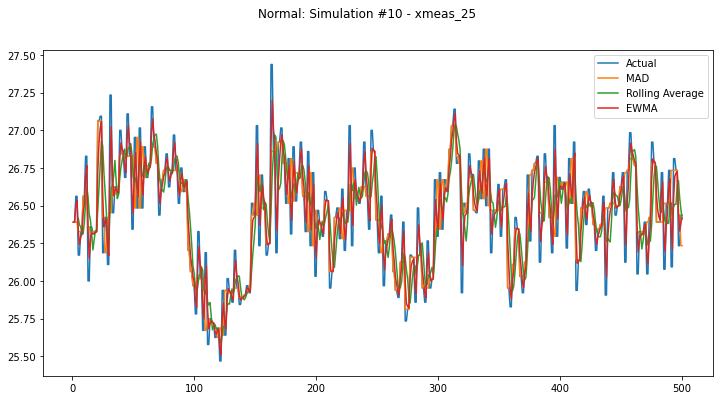

In [10]:
def plot_filtered_simulation_variable(dfs, simulation_run, title, variable, fault_number=0):
    fig, ax = plt.subplots(figsize=(12,6))
    for key in dfs.keys():    
        df = dfs[key]
        df_sim = df[(df.simulationRun == simulation_run)&(df.faultNumber==fault_number)]
        ax.plot(df_sim['sample'], df_sim[variable], label=key)
    
    ax.legend()
    fig.suptitle(f'{title}: Simulation #{simulation_run} - {variable}')

dfs_dict = {'Actual': X_train_normal,  'MAD': X_median_filtered, 'Rolling Average': X_rollavg_filtered, 'EWMA': X_ewma_filtered}#, 'Butter': X_butter_filtered}
plot_filtered_simulation_variable(dfs_dict, 10, 'Normal', 'xmeas_25')

## Modelling

### Batch-wise modelling

In [6]:
# Measured process data in the multiphase batch process are usually stored in the form of a three-dimensional cube
# I×J×K, recording K measured points with J process variables of all the I batches
I = X_train_normal.simulationRun.unique().shape[0]
K = X_train_normal['sample'].unique().shape[0]
J = len(X_train_normal.columns[3:])
print(f'I: {I}, J: {J}, K: {K}')

I: 500, J: 52, K: 500


### Training

In [82]:
from sklearn.pipeline import Pipeline

window = 5
pipe = Pipeline([('scale', RobustScaler()),
                ('reshape', LSTMAutoencoderTransformer(batch_size=K, window=window)), 
                ('encoder', LSTMAutoencoder(epochs=5, batch_size=128, validation_split=0.2))])

pv_columns = X_train_normal.columns[3:]
X_train = X_train_normal.iloc[:,3:].values
pipe.fit(X_train, None)

388/388 [==============================] - 26s 43ms/step - loss: 0.5577 - val_loss: 0.5437


Pipeline(steps=[('scale', RobustScaler()),
                ('reshape',
                 LSTMAutoencoderTransformer(batch_size=500, window=5)),
                ('encoder',
                 LSTMAutoencoder(batch_size=512, epochs=1,
                                 validation_split=0.2))])

In [83]:
X_pred = pipe.predict(X_train)

/home/victor/miniconda3/envs/dev-udacity-capstone/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


<AxesSubplot:ylabel='Count'>

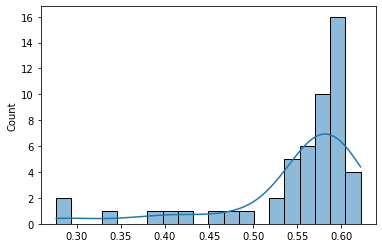

In [84]:
def inverse_transform(X, scale=False):
    if(scale):
        return pipe.named_steps['scale'].inverse_transform(LSTMAutoencoderTransformer.reverse_windowed_dataset(X, K, window))
    return LSTMAutoencoderTransformer.reverse_windowed_dataset(X, K, window)
    
X_train_pred = pd.DataFrame(inverse_transform(X_pred), columns=pv_columns, index=X_train_normal.index)
X_train_scaled = pd.DataFrame(pipe.named_steps['scale'].transform(X_train), columns=pv_columns, index=X_train_normal.index)

loss_mae = np.mean(np.abs(X_train_pred - X_train_scaled))

sns.histplot(x=loss_mae, kde=True, bins=20)

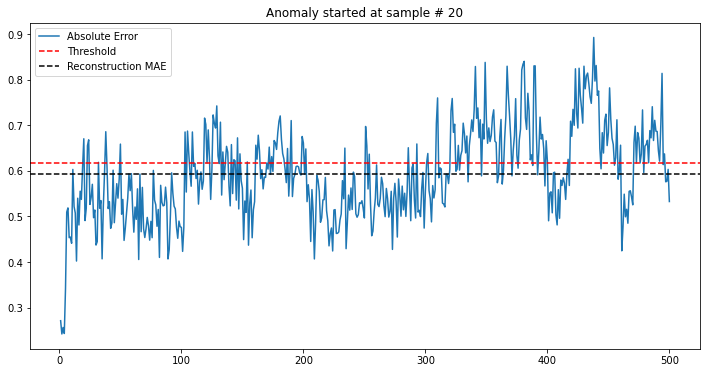

In [85]:
normal_pred_df = X_train_normal.copy()
normal_pred_df['faultNumber'] = X_train_normal.faultNumber.values
normal_pred_df['simulationRun'] = X_train_normal.simulationRun.values
normal_pred_df['sample'] = X_train_normal['sample'].values
normal_pred_df['loss_mae'] = np.mean(np.abs(X_train_pred - X_train_scaled), axis=1)

# plot the anomaly location
def plot_simulation_anomalies(df, simulation_run, threshold):    
    df_sim = df[(df.simulationRun == simulation_run)]
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(df_sim['sample'], df_sim['loss_mae'], label='Absolute Error')
    ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    ax.axhline(y=np.mean(df_sim['loss_mae']), color='k', linestyle='--', label='Reconstruction MAE')
    ax.set_title(f"Anomaly started at sample # {df_sim[df_sim['loss_mae']>threshold]['sample'].values[0]}")
    ax.legend()
    fig.show()

threshold = np.percentile(loss_mae, 99)
plot_simulation_anomalies(normal_pred_df, 2, threshold)

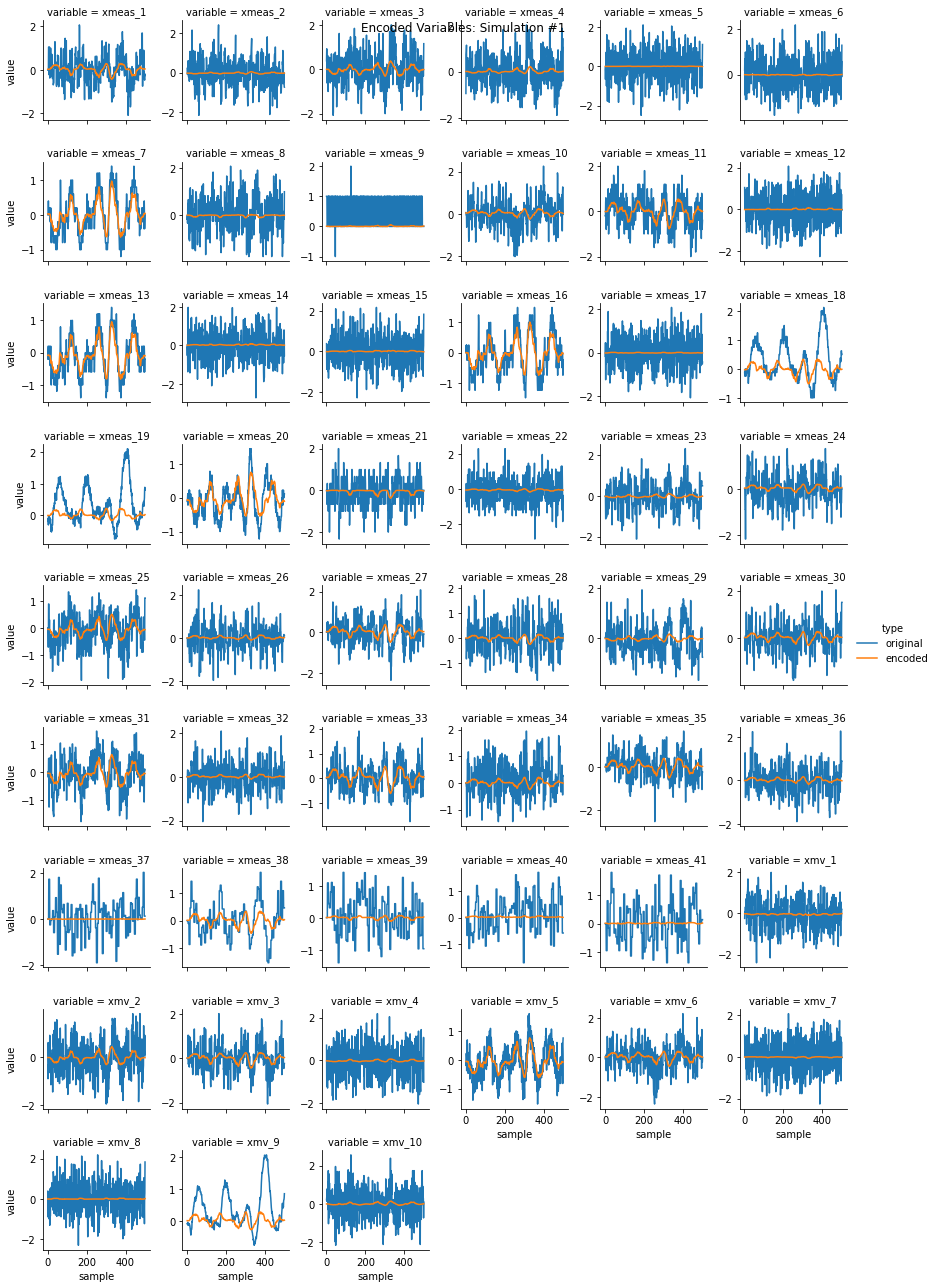

In [86]:
def plot_encoded_variables(df, df_rec, simulation_run, title, fault_number=0):
    process_variables = df.columns[:-4]
    df_sim = df[(df.simulationRun == simulation_run)&(df.faultNumber==fault_number)]
    df_sim_rec = df_rec[(df_rec.simulationRun == simulation_run)&(df_rec.faultNumber==fault_number)]

    df_melt = pd.melt(df_sim, id_vars=['sample'], value_vars=process_variables, var_name='variable', value_name='value')
    df_rec_melt = pd.melt(df_sim_rec, id_vars=['sample'], value_vars=process_variables, var_name='variable', value_name='value')

    df_melt['type'] = 'original'
    df_rec_melt['type'] = 'encoded'

    df_melt = pd.concat([df_melt, df_rec_melt], ignore_index=True) 

    rp = sns.relplot(data=df_melt, x='sample', y='value', hue='type', col='variable', kind='line', 
                col_wrap=6, height=2,
                 facet_kws={'sharey': False, 'sharex': True})
    rp.fig.suptitle(f'{title}: Simulation #{simulation_run}')


X_train_scaled['faultNumber'] = X_train_normal.faultNumber.values
X_train_scaled['simulationRun'] = X_train_normal.simulationRun.values
X_train_scaled['sample'] = X_train_normal['sample'].values

X_train_pred['faultNumber'] = X_train_normal.faultNumber.values
X_train_pred['simulationRun'] = X_train_normal.simulationRun.values
X_train_pred['sample'] = X_train_normal['sample'].values

plot_encoded_variables(X_train_scaled, X_train_pred, 1, 'Encoded Variables')

In [87]:
# get a scaled fault example
X_fault_sample = X_train_faulty.loc[X_train_faulty.faultNumber == 3]
fault_scaled = pd.DataFrame(pipe.named_steps['scale'].transform(X_fault_sample.iloc[:,3:].values), columns=X_train_faulty.iloc[:,3:].columns)

# predict the fault example
fault_pred_df = pd.DataFrame(inverse_transform(pipe.predict(X_fault_sample.iloc[:,3:].values)), columns=X_train_faulty.iloc[:,3:].columns)
fault_pred_df['faultNumber'] = X_fault_sample.faultNumber.values
fault_pred_df['simulationRun'] = X_fault_sample.simulationRun.values
fault_pred_df['sample'] = X_fault_sample['sample'].values

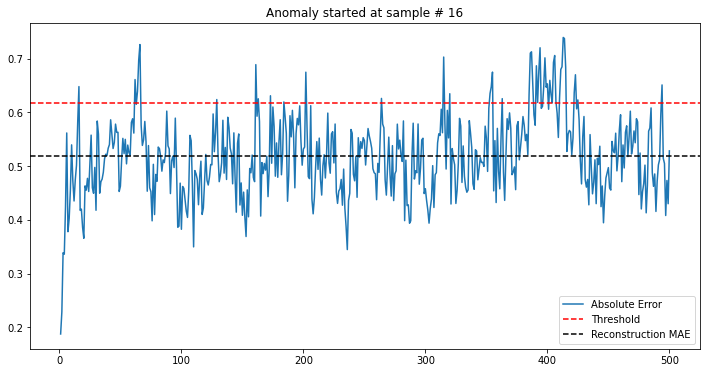

In [88]:
# calculate the reconstruction error
fault_pred_df['loss_mae'] = np.mean(np.abs(fault_pred_df - fault_scaled), axis=1)
plot_simulation_anomalies(fault_pred_df, 1, threshold)

## References
* https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf